In [1]:
import os
from gensim.models import KeyedVectors, Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.spatial.distance import cosine

In [2]:
# 데이터 경로 설정
data_dir = '/Users/jian_lee/Desktop/aiffel/data/topic_modelling'
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

# GoogleNews Word2Vec 모델 로드
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [3]:
# 형태소 분석기 초기화
okt = Okt()

# 폴더 경로 설정 (synopsis 폴더 안 모든 파일 대상)
folder_path = os.path.join(data_dir, "synopsis")

# 폴더 내 모든 파일 가져오기 (art_txt, gen_txt 제외)
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
             if f.endswith('.txt') and f not in ["synopsis_art.txt", "synopsis_gen.txt"]]

# 파일 존재 여부 확인
if not file_list:
    raise FileNotFoundError(f"⚠️ '{folder_path}' 폴더 내 .txt 파일이 없습니다.")

# 형태소 분석 후 명사 추출하는 함수
def read_token(file_name):
    result = []
    
    # 파일 존재 여부 확인
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"파일이 존재하지 않습니다: {file_name}")
    
    with open(file_name, "r", encoding="utf-8") as file:
        for line in file:
            words = okt.pos(line.strip(), stem=True, norm=True)
            result.extend([w[0] for w in words if w[1] == "Noun"])  # 명사만 추출
    return " ".join(result)

# 형태소 분석 수행
tokenized = [read_token(file_path) for file_path in file_list]

print(" 전체 형태소 분석 완료! 처리된 파일 개수:", len(file_list))

 전체 형태소 분석 완료! 처리된 파일 개수: 22


In [4]:
# Word2Vec 모델 생성
model = Word2Vec(sentences=[t.split() for t in tokenized], vector_size=100, window=5, min_count=3, sg=0)

# 모델 저장
model_path = os.path.join(folder_path, "word2vec.model")
model.save(model_path)
print(f"Word2Vec 모델 저장 완료: {model_path}")

Word2Vec 모델 저장 완료: /Users/jian_lee/Desktop/aiffel/data/topic_modelling/synopsis/word2vec.model


In [5]:
# 영화 구분 파일 경로
art_txt = os.path.join(folder_path, "/Users/jian_lee/Desktop/aiffel/data/topic_modelling/synopsis/synopsis_art.txt")
gen_txt = os.path.join(folder_path, "/Users/jian_lee/Desktop/aiffel/data/topic_modelling/synopsis/synopsis_gen.txt")

In [6]:
# 영화 장르 파일 리스트
genre_txt = [os.path.join(folder_path, f) for f in [
    "synopsis_SF.txt", "synopsis_family.txt", "synopsis_show.txt", 
    "synopsis_horror.txt", "synopsis_etc.txt", "synopsis_documentary.txt", 
    "synopsis_drama.txt", "synopsis_romance.txt", "synopsis_musical.txt", 
    "synopsis_mystery.txt", "synopsis_crime.txt", "synopsis_historical.txt", 
    "synopsis_western.txt", "synopsis_adult.txt", "synopsis_thriller.txt", 
    "synopsis_animation.txt", "synopsis_action.txt", "synopsis_adventure.txt", 
    "synopsis_war.txt", "synopsis_comedy.txt", "synopsis_fantasy.txt"
]]

genre_names = [
    "SF", "가족", "공연", "공포(호러)", "기타", "다큐멘터리", "드라마", "멜로로맨스", "뮤지컬", "미스터리", 
    "범죄", "사극", "서부극(웨스턴)", "성인물(에로)", "스릴러", "애니메이션", "액션", "어드벤처", "전쟁", "코미디", "판타지"
]

In [7]:
# 영화 구분 데이터
art = read_token(art_txt) # 예술영화 데이터를 형태소 분석하여 명사 리스트로 변환
gen = read_token(gen_txt) # 일반영화 데이터를 형태소 분석하여 명사 리스트로 변환

# 장르 데이터
genre_texts = [read_token(file) for file in genre_txt] # 모든 장르의 텍스트 데이터를 형태소 분석하여 명사 리스트로 변환

In [8]:
# TF-IDF 벡터화: 영화 구분(예술영화 vs 일반영화) 및 각 장르별 단어 중요도를 분석하기 위해 사용
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen] + genre_texts)  # 예술영화, 일반영화, 각 장르의 텍스트 데이터 변환

# TF-IDF 행렬 변환 (sparse matrix -> dense matrix로 변환하여 사용)
m = [X[i].tocoo() for i in range(X.shape[0])]  # 각 문서(예술영화, 일반영화, 장르)의 TF-IDF 값을 포함하는 리스트 생성

# 단어별 TF-IDF 점수 추출
w = [[(i, j) for i, j in zip(mm.col, mm.data)] for mm in m]  
# 각 문서(예술영화, 일반영화, 장르)에서 단어의 인덱스(i)와 해당 단어의 TF-IDF 점수(j)를 추출하여 리스트로 저장

# TF-IDF 점수 기준으로 정렬 (TF-IDF 값이 높은 단어일수록 해당 문서에서 중요한 의미를 가짐)
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)  # TF-IDF 값 기준으로 내림차순 정렬

# Target 단어 셋 (예술영화 vs 일반영화)
target_art, target_gen = [], []  # 예술영화 및 일반영화를 대표하는 단어 목록 저장
n = 15  # 각 단어 셋에서 추출할 단어 개수 (15개)

# 예술영화를 대표하는 단어 추출
for i in range(100):  # 상위 100개의 TF-IDF 단어를 확인하며 선택
    word = vectorizer.get_feature_names_out()[w[0][i][0]]  # 예술영화에서 TF-IDF가 높은 단어 가져오기
    if word not in [vectorizer.get_feature_names_out()[w[1][j][0]] for j in range(100)]:  # 일반영화에 포함되지 않은 단어 선택
        target_art.append(word)  
    if len(target_art) == n:  # 목표 개수(15개)에 도달하면 종료
        break

# 일반영화를 대표하는 단어 추출
for i in range(100):  # 상위 100개의 TF-IDF 단어를 확인하며 선택
    word = vectorizer.get_feature_names_out()[w[1][i][0]]  # 일반영화에서 TF-IDF가 높은 단어 가져오기
    if word not in [vectorizer.get_feature_names_out()[w[0][j][0]] for j in range(100)]:  # 예술영화에 포함되지 않은 단어 선택
        target_gen.append(word)  
    if len(target_gen) == n:  # 목표 개수(15개)에 도달하면 종료
        break

#  Attribute 단어 셋 (각 장르별 단어 15개씩 추출)
attributes = []  # 각 장르를 대표하는 단어 리스트

for i in range(2, len(w)):  # 2부터 시작하는 이유: art(0), gen(1) 제외하고 장르 부분만 가져옴
    attr = []  # 현재 장르의 대표 단어 저장
    for j in range(100):  # 상위 100개의 TF-IDF 단어를 확인하며 선택
        word = vectorizer.get_feature_names_out()[w[i][j][0]]  # 해당 장르에서 TF-IDF가 높은 단어 가져오기
        if word in vectorizer.get_feature_names_out() and word not in target_art + target_gen:  
            # 예술영화/일반영화를 대표하는 단어(target_art, target_gen)에는 포함되지 않은 단어만 선택
            attr.append(word)
        if len(attr) == n:  # 목표 개수(15개)에 도달하면 종료
            break
    attributes.append(attr)  # 각 장르별 대표 단어 리스트에 추가

# 최종 결과 출력
print("\n 예술영화를 대표하는 단어들:", target_art)
print("\n 일반영화를 대표하는 단어들:", target_gen)
print("\n 각 장르를 대표하는 단어들:")
for i, attr in enumerate(attributes):
    print(f"{genre_names[i]}:", attr)


 예술영화를 대표하는 단어들: ['음악', '위기', '최고', '지금', '운명', '결심', '여인', '충격', '이름', '이후', '준비', '감정', '그린', '상처', '만난']

 일반영화를 대표하는 단어들: ['서울', '애니메이션', '작품', '여성', '섹스', '부문', '연출', '다큐멘터리', '가지', '대해', '주인공', '사회', '회사', '다큐', '존재']

 각 장르를 대표하는 단어들:
SF: ['위해', '자신', '지구', '시작', '사람', '인류', '인간', '미래', '우주', '그녀', '세계', '로봇', '모든', '박사', '우주선']
가족: ['엄마', '아빠', '가족', '영화제', '자신', '위해', '친구', '아버지', '시작', '그녀', '아주르', '아들', '마을', '국제', '할머니']
공연: ['사랑', '오페라', '실황', '토스카', '자신', '올레', '그녀', '카바', '공연', '리골레토', '위해', '백작', '오텔로', '프레', '왕자']
공포(호러): ['시작', '위해', '사람', '자신', '친구', '그녀', '사건', '공포', '발견', '죽음', '마을', '가족', '남자', '악령', '좀비']
기타: ['영화제', '국제', '단편', '영화', '자신', '사람', '이야기', '그녀', '남자', '위해', '시작', '사랑', '뉴미디어', '페스티벌', '여자']
다큐멘터리: ['영화제', '영화', '국제', '사람', '이야기', '대한', '자신', '감독', '위해', '우리', '시작', '세계', '통해', '그녀', '가족']
드라마: ['자신', '영화제', '그녀', '사람', '사랑', '영화', '위해', '시작', '국제', '남자', '친구', '이야기', '엄마', '여자', '아버지']
멜로로맨스: ['그녀', '사랑', '자신', '시작', '남편', '남자', '여자', '사람', '친구', '

- 코미디와 판타지의 대표단어가 유사하게 나오는 것을 확인하였음.

In [9]:
# WEAT(Word Embedding Association Test) 점수 계산 함수
def weat_score(target_X, target_Y, attribute_A, attribute_B, model):
    """
    WEAT 점수를 계산하는 함수.
    - target_X, target_Y: 비교할 두 개의 타겟 단어 셋 (예술영화 vs 일반영화)
    - attribute_A, attribute_B: 비교할 속성 단어 셋 (영화 장르별 단어 셋)
    - model: Word2Vec 모델
    """

    # 단어와 속성(attribute) 단어 셋 간의 평균 유사도를 계산하는 함수
    def association(word, attr_set):
        return np.mean([1 - cosine(model.wv[word], model.wv[attr]) 
                        for attr in attr_set if attr in model.wv])  # 코사인 유사도를 기반으로 연관성 측정

    # 특정 타겟 단어 셋(target)이 두 속성(attribute_A, attribute_B)과 얼마나 차이가 나는지 계산하는 함수
    def differential_association(target, attr_A, attr_B):
        return np.mean([association(word, attr_A) for word in target if word in model.wv]) - \
               np.mean([association(word, attr_B) for word in target if word in model.wv])

    # 최종 WEAT 점수 계산
    score = differential_association(target_X, attribute_A, attribute_B) - \
            differential_association(target_Y, attribute_A, attribute_B)
    
    return score  # 결과값 반환 (양수 → target_X와 attribute_A 연관, 음수 → target_X와 attribute_B 연관)

# 🎬 WEAT 점수 계산 (모든 장르에 대해 수행)
weat_scores = []

for i, attr in enumerate(attributes):  # 각 장르별로 WEAT 점수 계산
    score = weat_score(target_art, target_gen, attr, attributes[(i+1) % len(attributes)], model)  
    # 현재 장르(attr)와 다음 장르(attributes[(i+1) % len(attributes)])를 비교
    weat_scores.append(score)

In [13]:
# 한글 폰트 설정 (예: 맑은 고딕)
# plt.rc("font", family="Malgun Gothic")  # Windows
plt.rc("font", family="AppleGothic")  # Mac 사용 시

# 마이너스(-) 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

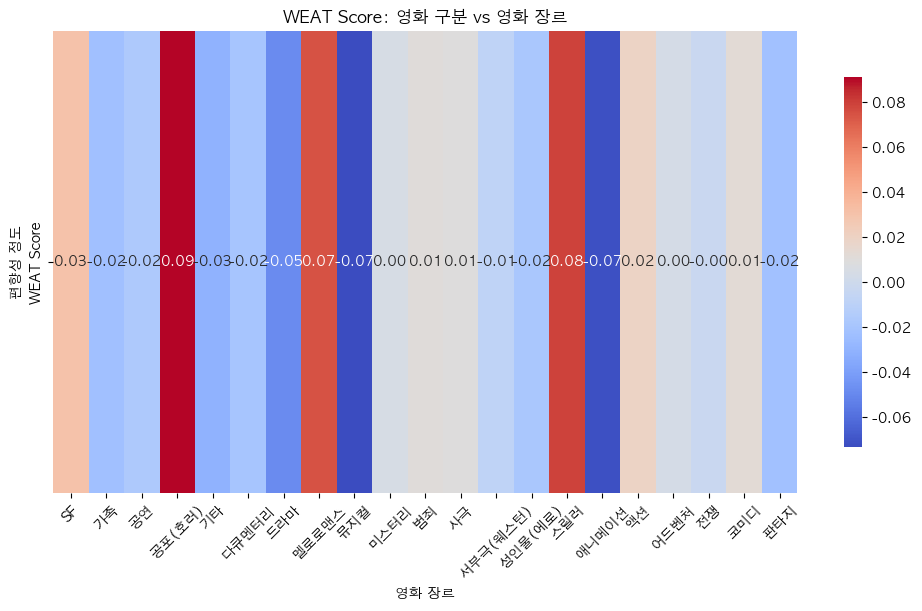

In [24]:
plt.figure(figsize=(12, 6))  # 그래프 크기 설정

sns.heatmap(np.array(weat_scores).reshape(1, -1),  
            annot=True, fmt=".2f", cmap="coolwarm", 
            annot_kws={"size": 10},  # 숫자 크기 조정
            xticklabels=genre_names, 
            yticklabels=["WEAT Score"], 
            cbar_kws={"shrink": 0.8})  # 컬러바 크기 조정

plt.title("WEAT Score: 영화 구분 vs 영화 장르")  
plt.xlabel("영화 장르")  
plt.ylabel("편향성 정도")  
plt.xticks(rotation=45)  # X축 라벨 기울기 조정
plt.show()

In [17]:
# 편향성이 두드러지는 장르 강조
threshold = np.percentile(np.abs(weat_scores), 90)  # WEAT 점수의 절댓값 상위 10%를 기준으로 강조
highlight_genres = [genre_names[i] for i, score in enumerate(weat_scores) if abs(score) >= threshold]

# 결과 출력
print("\n 편향성이 두드러지는 영화 장르:", highlight_genres)


 편향성이 두드러지는 영화 장르: ['공포(호러)', '멜로로맨스', '스릴러']


---

## 회고

- 아직 코미디와 판타지 항목에 대한 대표단어 데이터셋이 중복되는 부분이 많은데 이 부분을 해결하지 못한게 아쉽습니다.
- 현재는 노드를 기반으로 실험을 수행했지만, 다른 모델을 사용해보는 등 추가 실험을 해볼 계획입니다.